##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Running TFLite models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%201/Examples/TFLite_Week1_Linear_Regression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%201/Examples/TFLite_Week1_Linear_Regression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.1.0


## Create a Basic Model of the Form y = mx + c

In [2]:
# Create a simple Keras model.
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=[1])
])

model.compile(optimizer='sgd',
              loss='mean_squared_error')

model.fit(x, y, epochs=200)

Train on 6 samples
Epoch 1/200
6/6 [==============================] - 0s 47ms/sample - loss: 24.7981
Epoch 2/200
6/6 [==============================] - 0s 2ms/sample - loss: 19.7993
Epoch 3/200
6/6 [==============================] - 0s 1ms/sample - loss: 15.8606
Epoch 4/200
6/6 [==============================] - 0s 2ms/sample - loss: 12.7560
Epoch 5/200
6/6 [==============================] - 0s 2ms/sample - loss: 10.3077
Epoch 6/200
6/6 [==============================] - 0s 1ms/sample - loss: 8.3759
Epoch 7/200
6/6 [==============================] - 0s 1ms/sample - loss: 6.8507
Epoch 8/200
6/6 [==============================] - 0s 2ms/sample - loss: 5.6453
Epoch 9/200
6/6 [==============================] - 0s 2ms/sample - loss: 4.6917
Epoch 10/200
6/6 [==============================] - 0s 1ms/sample - loss: 3.9363
Epoch 11/200
6/6 [==============================] - 0s 2ms/sample - loss: 3.3370
Epoch 12/200
6/6 [==============================] - 0s 3ms/sample - loss: 2.8605
Epoch 13/200

Epoch 102/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1846
Epoch 103/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1808
Epoch 104/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1771
Epoch 105/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1735
Epoch 106/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1699
Epoch 107/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1664
Epoch 108/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1630
Epoch 109/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1596
Epoch 110/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1564
Epoch 111/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1531
Epoch 112/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1500
Epoch 113/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1469
Epoch 114/200
6/

## Generate a SavedModel

In [3]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/1/assets


## Convert the SavedModel to TFLite

In [4]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [5]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

780

## Initialize the TFLite Interpreter To Try It Out

In [6]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [9]:
print(input_details)
print(output_details)

[{'name': 'dense_input', 'index': 3, 'shape': array([1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'Identity', 'index': 0, 'shape': array([1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [10]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputs.append(input_data[0][0])
    outputs.append(output_data[0][0])

## Visualize the Model

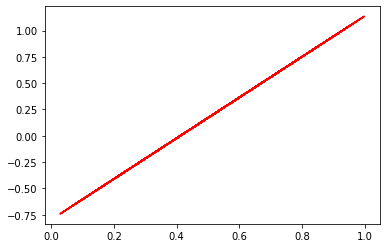

In [11]:
%matplotlib inline

plt.plot(inputs, outputs, 'r')
plt.show()

## Download the TFLite Model File

If you are running this notebook in a Colab, you can run the cell below to download the tflite model to your local disk. 

**Note**: If the file does not download when you run the cell, try running the cell a second time.

In [13]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    print("no download")
    pass

no download
